In [1]:
'''
Huggingface BERT Model: dccuchile/bert-base-spanish-wwm-uncased
https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased

Necessary installations: Python, Pandas, Numpy, Sklearn, PyTorch, transformers, TrainingArguments, tensorflow, spacy, 
python -m spacy download es_core_news_sm
'''

'\nHuggingface BERT Model: dccuchile/bert-base-spanish-wwm-uncased\nhttps://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased\n'

In [1]:
import pandas as pd
import numpy as np
import sklearn 
from transformers import TrainingArguments

In [2]:
df = pd.read_csv('data/dataset.csv')
print(df.head(25))

                                                input  intent
0                      Quisiera comprar una camiseta.       1
1                     Me gustaría pedir una camiseta.       1
2                        Necesito una camiseta nueva.       1
3                     Quiero una camiseta de algodón.       1
4        Estoy buscando una camiseta en talla grande.       1
5           Deseo comprar una camiseta con estampado.       1
6            ¿Puedo pedir una camiseta en color azul?       1
7            Necesitaría una camiseta de manga corta.       1
8         Estoy interesado en una camiseta deportiva.       1
9            Quiero comprar una camiseta para correr.       1
10           Me gustaría adquirir una camiseta negra.       1
11                Quisiera una camiseta sin etiqueta.       1
12              Necesito una camiseta para un regalo.       1
13         Deseo pedir una camiseta en talla mediana.       1
14              ¿Podría tener una camiseta en oferta?       1
15      

In [3]:
# Parts of Speech (POS)
import spacy

# Carga modelo de Spanish NLP 
nlp = spacy.load("es_core_news_sm")

def get_pos_tags(text):
    # Process the text with spaCy
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]  # Extract each word and its POS tag 
    return pos_tags

# ejemplo
sentence = "¿Cómo puedo cambiar mi contraseña?"
pos_tags = get_pos_tags(sentence)
print(pos_tags)


[('¿', 'PUNCT'), ('Cómo', 'PRON'), ('puedo', 'AUX'), ('cambiar', 'VERB'), ('mi', 'DET'), ('contraseña', 'NOUN'), ('?', 'PUNCT')]


In [4]:
# Apply POS tagging to a column of df (no sé si mejora el rendimiento del modelo todavia, podemos studiarlo...)
df['pos_tags'] = df['input'].apply(get_pos_tags)

In [5]:
df.head()

,input,intent,pos_tags
0,Quisiera comprar una camiseta.,1,"[(Quisiera, VERB), (comprar, VERB), (una, DET)..."
1,Me gustaría pedir una camiseta.,1,"[(Me, PRON), (gustaría, VERB), (pedir, VERB), ..."
2,Necesito una camiseta nueva.,1,"[(Necesito, VERB), (una, DET), (camiseta, NOUN..."
3,Quiero una camiseta de algodón.,1,"[(Quiero, VERB), (una, DET), (camiseta, NOUN),..."
4,Estoy buscando una camiseta en talla grande.,1,"[(Estoy, AUX), (buscando, VERB), (una, DET), (..."


In [6]:
from sklearn.model_selection import train_test_split

train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(df['input'], df['intent'], test_size=0.1)  # Reserving 10% for testing
train_texts, val_texts, train_labels, val_labels = train_test_split(train_val_texts, train_val_labels, test_size=0.2)  # Split remaining 90% into training and validation

In [7]:
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder

tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

# already split data into train_texts, val_texts, test_texts, & train_labels, val_labels, and test_labels

# Tokenize texts: for train, valuation and test
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)  

# Encodes labels: train, valuation and test
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)  

In [8]:
'''
Creates instances of the IntentDataset for training, validation, and testing.
Way to "wrap" input data and labels for an intent classification task into a PyTorch format.
En fin:
Prepara los datos para el entrenamiento, la validación y el testeo en nuestro modelo de ML con PyTorch.
'''

import torch

class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert all sets to PyTorch datasets 
train_dataset = IntentDataset(train_encodings, train_labels_encoded)
val_dataset = IntentDataset(val_encodings, val_labels_encoded)
test_dataset = IntentDataset(test_encodings, test_labels_encoded) 

In [9]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = len(set(train_labels_encoded))
model = AutoModelForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# Todo esto viene del BETO pre-trained modelo de Hugging Face

from transformers import TrainingArguments, Trainer, SchedulerType

training_args = TrainingArguments(
    output_dir='./results',             # creates output directory for model and logs
    num_train_epochs=4,                 # number of training epochs: +1 for Fine-Tuning
    per_device_train_batch_size=60,     # batch size: Training
    per_device_eval_batch_size=192,     # batch size: Evaluation
    warmup_steps=500,                   # n warmup steps
    weight_decay=0.01,                  # strength of weight decay
    logging_dir='./logs',               # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",        # evaluate each `logging_steps`
    learning_rate=5e-5,                 # initial learning rate
    lr_scheduler_type=SchedulerType.LINEAR,  # used Cosine scheduler with warmup, works better than Linear
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

c:\Users\dusti\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.48166704177856445, 'eval_runtime': 1.4361, 'eval_samples_per_second': 45.261, 'eval_steps_per_second': 0.696, 'epoch': 1.0}
{'loss': 0.2216, 'grad_norm': 2.060570001602173, 'learning_rate': 1.0000000000000002e-06, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.47965008020401, 'eval_runtime': 1.489, 'eval_samples_per_second': 43.654, 'eval_steps_per_second': 0.672, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.4759402871131897, 'eval_runtime': 1.5023, 'eval_samples_per_second': 43.267, 'eval_steps_per_second': 0.666, 'epoch': 3.0}
{'loss': 0.226, 'grad_norm': 8.203481674194336, 'learning_rate': 2.0000000000000003e-06, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.47249990701675415, 'eval_runtime': 1.4823, 'eval_samples_per_second': 43.851, 'eval_steps_per_second': 0.675, 'epoch': 4.0}
{'train_runtime': 84.7486, 'train_samples_per_second': 12.224, 'train_steps_per_second': 0.236, 'train_loss': 0.22378964424133302, 'epoch': 4.0}


TrainOutput(global_step=20, training_loss=0.22378964424133302, metrics={'train_runtime': 84.7486, 'train_samples_per_second': 12.224, 'train_steps_per_second': 0.236, 'train_loss': 0.22378964424133302, 'epoch': 4.0})

In [44]:
# Evaluate training set, eval_loss : most important, we want it to be as low as possible
trainer.evaluate()

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.47249990701675415,
 'eval_runtime': 1.395,
 'eval_samples_per_second': 46.596,
 'eval_steps_per_second': 0.717,
 'epoch': 4.0}

In [45]:
# evaluate test set
test_results = trainer.evaluate(test_dataset)
print(test_results)

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.3650301992893219, 'eval_runtime': 0.6852, 'eval_samples_per_second': 53.998, 'eval_steps_per_second': 1.459, 'epoch': 4.0}


In [46]:
# Metricas:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels = test_labels_encoded  # True labels
predictions = trainer.predict(test_dataset).predictions.argmax(axis=1)  # Model predictions

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')  # Used 'weighted' for imbalanced classes but unnecessary here
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 0.918918918918919
Precision: 0.9191236691236692
Recall: 0.918918918918919
F1 Score: 0.917940797940798


In [47]:
# Fine-tuning y sus Metricas: 
# La diferencia entre la primera y segunda columna es el aumento de 120 frases nuevas en el dataset
# Evaluation_Loss se basa en test dataset

cols = ['Epochs', 'Evaluation_Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'Tiempo', 'LR_scheduler_type', 'Training_Batch_Size', 'Evaluation_Batch_Size']
df_metricas = pd.DataFrame(index=range(8), columns=cols)
df_metricas.loc[0] = [3, 0.98, 0.56, 0.532, 0.56, 0.537, 1.12, 'NaN', 16, 64]
df_metricas.loc[1] = [3, 0.97, 0.81, 0.829, 0.81, 0.817, 1.22, 'NaN', 16, 64]
df_metricas.loc[2] = [3, 0.838, 0.729, 0.809, 0.729, 0.69, 1.36, 'Cosine', 16, 64]
df_metricas.loc[3] = [3, 0.642, 0.757, 0.756, 0.757, 0.739, 2.00, 'Linear', 16, 64]
df_metricas.loc[4] = [3,  0.571, 0.784, 0.784, 0.784, 0.773, 1.34, 'Cosine', 24, 128]
df_metricas.loc[5] = [3, 0.541, 0.811, 0.822, 0.811, 0.797, 1.15, 'Cosine', 36, 128]
df_metricas.loc[6] = [4, 0.481, 0.839, 0.845, 0.839, 0.829, 1.38, 'Cosine', 36, 128]
df_metricas.loc[7] = [4, 0.450, 0.892, 0.896, 0.892, 0.889, 1.39, 'Cosine', 44, 128]
df_metricas.loc[8] = [4, 0.417, 0.892, 0.896, 0.892, 0.889, 1.33, 'Cosine', 44, 192]
df_metricas.loc[9] = [4, 0.393, 0.892, 0.896, 0.892, 0.889, 1.28, 'Cosine', 52, 192]
df_metricas.loc[10] = [4, 0.365, 0.919, 0.919, 0.919, 0.918, 1.24, 'Cosine', 60, 192]

df_metricas

,Epochs,Evaluation_Loss,Accuracy,Precision,Recall,F1,Tiempo,LR_scheduler_type,Training_Batch_Size,Evaluation_Batch_Size
0,3,0.98,0.56,0.532,0.56,0.537,1.12,NaN,16,64
1,3,0.97,0.81,0.829,0.81,0.817,1.22,NaN,16,64
2,3,0.838,0.729,0.809,0.729,0.69,1.36,Cosine,16,64
3,3,0.642,0.757,0.756,0.757,0.739,2.0,Linear,16,64
4,3,0.571,0.784,0.784,0.784,0.773,1.34,Cosine,24,128
5,3,0.541,0.811,0.822,0.811,0.797,1.15,Cosine,36,128
6,4,0.481,0.839,0.845,0.839,0.829,1.38,Cosine,36,128
7,4,0.45,0.892,0.896,0.892,0.889,1.39,Cosine,44,128
8,4,0.417,0.892,0.896,0.892,0.889,1.33,Cosine,44,192
9,4,0.393,0.892,0.896,0.892,0.889,1.28,Cosine,52,192


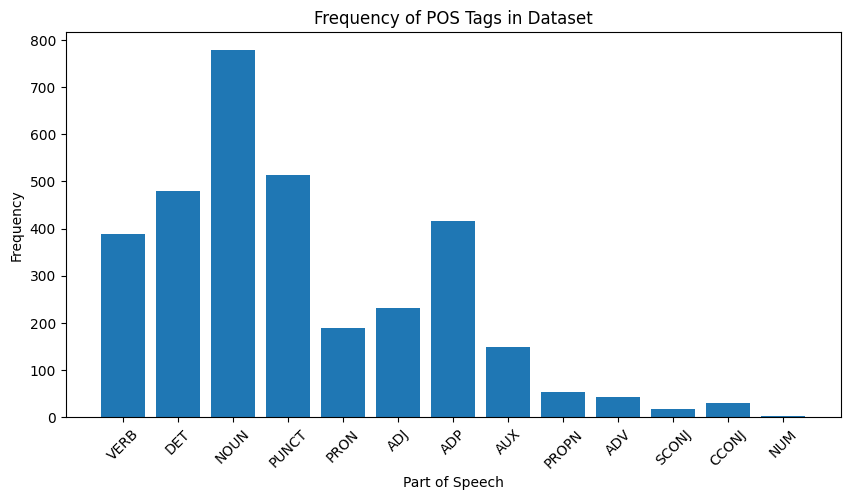

In [42]:
# Representacion visual de POS para que podamos ver las frecuencias:

from collections import Counter
import matplotlib.pyplot as plt

# df['pos_tags'] contains lists of (word, POS) tuples
pos_counts = Counter([pos for row in df['pos_tags'] for _, pos in row])

plt.figure(figsize=(10, 5))
plt.bar(pos_counts.keys(), pos_counts.values())
plt.xlabel('Part of Speech')
plt.ylabel('Frequency')
plt.title('Frequency of POS Tags in Dataset')
plt.xticks(rotation=45)
plt.show()

In [46]:
# Función de Prediccion de intents del input (frase)

def predict_intent(frase):
    # Tokenize input 
    inputs = tokenizer(frase, padding=True, truncation=True, max_length=128, return_tensors="pt")   #pt = pytorch

    # Predict
    with torch.no_grad():
        logits = model(**inputs).logits

    # Get predicted label ID
    predicted_label_id = logits.argmax().item()

    # Decode label ID back to label name, el [0] indica que usa el primer elemento de la columna intent, en nuestro caso: 1 
    predicted_label = label_encoder.inverse_transform([predicted_label_id])[0]
    return predicted_label

# Probar input para verificar intent, funciona bien con 2 pero no siempre con 1 y 2
frase = "Me gustaría una camiseta negra"
predicted_intent = predict_intent(frase)
print(f"Predicted intent: {predicted_intent}")

Predicted intent: 1
